In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import time
from IPython.display import clear_output

class RealTimeTradingBot:
    def __init__(self, stocks, initial_capital=10000):
        self.stocks = stocks
        self.capital = initial_capital
        self.portfolio = {}
        self.trading_history = []
        self.csv_filename = "stock_data.csv"

    def save_to_csv(self, symbol, data):
        """Save stock data to a CSV file."""
        try:
            data['Symbol'] = symbol
            if not pd.io.common.file_exists(self.csv_filename):
                data.to_csv(self.csv_filename, index=False)
            else:
                data.to_csv(self.csv_filename, mode='a', header=False, index=False)
        except Exception as e:
            print(f"Error saving data for {symbol}: {e}")

    def get_stock_data(self, symbol):
        """Fetch stock data and calculate key metrics."""
        try:
            stock = yf.Ticker(symbol)
            history = stock.history(period="1d", interval="1m").reset_index()
            self.save_to_csv(symbol, history[['Datetime', 'Open', 'High', 'Low', 'Close', 'Volume']])

            # Calculate moving average for noise reduction
            moving_average = history['Close'].rolling(window=5).mean().iloc[-1]

            return {
                'current_price': history['Close'].iloc[-1],
                'mean_price': history['Close'].mean(),
                'moving_average': moving_average,
                'recent_trend': self._calculate_trend(history['Close'])
            }
        except Exception as e:
            print(f"Error fetching {symbol} data: {e}")
            return None

    def _calculate_trend(self, prices):
        """Calculate trend using linear regression."""
        x = np.arange(len(prices))
        slope, _ = np.polyfit(x, prices, 1)
        return slope

    def predict_action(self, stock_data):
        """Predict trading action based on stock data."""
        current_price = stock_data['current_price']
        mean_price = stock_data['mean_price']
        moving_average = stock_data['moving_average']
        trend = stock_data['recent_trend']

        # Predictive logic
        if current_price < moving_average * 0.95 and trend > 0:
            return "BUY"
        elif current_price > moving_average * 1.05 and trend < 0:
            return "SELL"
        return "HOLD"

    def execute_trade(self, symbol, action, price):
        """Simulate trade execution."""
        if action == "BUY" and self.capital > price:
            shares = int(self.capital * 0.2 // price)
            if shares > 0:
                self.portfolio[symbol] = self.portfolio.get(symbol, 0) + shares
                self.capital -= shares * price
                self.trading_history.append({'action': 'BUY', 'symbol': symbol, 'shares': shares, 'price': price})

        elif action == "SELL" and symbol in self.portfolio:
            shares = self.portfolio.pop(symbol, 0)
            self.capital += shares * price
            self.trading_history.append({'action': 'SELL', 'symbol': symbol, 'shares': shares, 'price': price})

    def track_and_trade(self, duration=300, interval=5):
        """Real-time tracking and trading with clean outputs."""
        start_time = time.time()
        while time.time() - start_time < duration:
            clear_output(wait=True)  # Clean output for better readability
            print(f"TRADING BOT REAL-TIME ANALYSIS (Refresh every {interval}s)")
            print(f"Current Capital: ${self.capital:.2f}")
            print(f"Portfolio: {self.portfolio}")
            print("-" * 40)

            for symbol in self.stocks:
                stock_data = self.get_stock_data(symbol)
                if stock_data:
                    action = self.predict_action(stock_data)
                    self.execute_trade(symbol, action, stock_data['current_price'])
                    print(f"{symbol}: Price: ${stock_data['current_price']:.2f}, Action: {action}")
                    print(f"Moving Avg: ${stock_data['moving_average']:.2f}, Trend: {stock_data['recent_trend']:.5f}")
                    print("-" * 40)

            time.sleep(interval)  # Adjust refresh rate here

        print("Trading session completed.")
        print(f"Final Portfolio: {self.portfolio}")
        print(f"Remaining Capital: ${self.capital:.2f}")

# Usage
stocks = ['AAPL', 'GOOGL', 'MSFT', 'AMZN']
bot = RealTimeTradingBot(stocks)
bot.track_and_trade(duration=300, interval=5)  # 5-second refresh for 5 minutes


TRADING BOT REAL-TIME ANALYSIS (Refresh every 5s)
Current Capital: $10000.00
Portfolio: {}
----------------------------------------


C:\Users\Yatharth Jain\AppData\Local\Temp\ipykernel_4608\2842832226.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Symbol'] = symbol
C:\Users\Yatharth Jain\AppData\Local\Temp\ipykernel_4608\2842832226.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Symbol'] = symbol


AAPL: Price: $228.34, Action: HOLD
Moving Avg: $228.12, Trend: 0.00076
----------------------------------------
GOOGL: Price: $178.13, Action: HOLD
Moving Avg: $178.26, Trend: 0.00830
----------------------------------------


C:\Users\Yatharth Jain\AppData\Local\Temp\ipykernel_4608\2842832226.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Symbol'] = symbol
C:\Users\Yatharth Jain\AppData\Local\Temp\ipykernel_4608\2842832226.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Symbol'] = symbol


MSFT: Price: $417.63, Action: HOLD
Moving Avg: $417.53, Trend: 0.01413
----------------------------------------
AMZN: Price: $204.60, Action: HOLD
Moving Avg: $204.48, Trend: 0.00929
----------------------------------------


KeyboardInterrupt: 

In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

class RealTimeTradingBot:
    def __init__(self, stocks, initial_capital=10000, csv_filename="trading_data.csv"):
        self.stocks = stocks
        self.capital = initial_capital
        self.portfolio = {}
        self.trading_history = []
        self.csv_filename = csv_filename
        self.column_names = ['Time', 'Symbol', 'Price', 'Action', 'Portfolio', 'Capital']
        self._initialize_csv()
        self.visualization_data = {'Time': [], 'Portfolio Value': [], 'Capital': []}

    def _initialize_csv(self):
        """Initialize the CSV file with column names if it doesn't exist."""
        try:
            pd.read_csv(self.csv_filename)
        except FileNotFoundError:
            df = pd.DataFrame(columns=self.column_names)
            df.to_csv(self.csv_filename, index=False)

    def get_stock_data(self, symbol):
        """Fetch comprehensive stock data"""
        try:
            stock = yf.Ticker(symbol)
            history = stock.history(period="1mo")
            return {
                'current_price': history['Close'][-1],
                'mean_price': history['Close'].mean(),
                'std_dev': history['Close'].std(),
                'recent_trend': self._calculate_trend(history['Close'])
            }
        except Exception as e:
            print(f"Error fetching {symbol} data: {e}")
            return None

    def _calculate_trend(self, prices):
        """Calculate price trend using linear regression"""
        x = np.arange(len(prices))
        slope, _ = np.polyfit(x, prices, 1)
        return slope

    def predict_action(self, stock_data):
        """Predict trading action based on data."""
        current_price = stock_data['current_price']
        mean_price = stock_data['mean_price']
        trend = stock_data['recent_trend']

        if current_price < mean_price * 0.95 and trend > 0:
            return "BUY"
        elif current_price > mean_price * 1.05 and trend < 0:
            return "SELL"
        return "HOLD"

    def execute_trade(self, symbol, action, price):
        """Simulate trade execution."""
        if action == "BUY" and self.capital > price:
            shares = int(self.capital * 0.2 // price)
            if shares > 0:
                self.portfolio[symbol] = self.portfolio.get(symbol, 0) + shares
                spent = shares * price
                self.capital -= spent
                self.trading_history.append({'action': 'BUY', 'symbol': symbol, 'shares': shares, 'price': price})
        elif action == "SELL" and symbol in self.portfolio:
            shares = self.portfolio[symbol]
            revenue = shares * price
            self.capital += revenue
            del self.portfolio[symbol]
            self.trading_history.append({'action': 'SELL', 'symbol': symbol, 'shares': shares, 'price': price})

    def save_to_csv(self, symbol, stock_data, action):
        """Save stock data and trading actions to CSV."""
        current_time = time.strftime("%Y-%m-%d %H:%M:%S")
        portfolio_value = sum(shares * yf.Ticker(s).history(period="1d")['Close'][-1] for s, shares in self.portfolio.items())
        data = {
            'Time': current_time,
            'Symbol': symbol,
            'Price': stock_data['current_price'],
            'Action': action,
            'Portfolio': str(self.portfolio),
            'Capital': self.capital
        }
        df = pd.DataFrame([data])
        df.to_csv(self.csv_filename, mode='a', header=False, index=False)

        # Update visualization data
        self.visualization_data['Time'].append(current_time)
        self.visualization_data['Portfolio Value'].append(self.capital + portfolio_value)
        self.visualization_data['Capital'].append(self.capital)

    def track_and_trade(self, duration=300, interval=5):
        """Track and trade stocks for the specified duration."""
        start_time = time.time()
        while time.time() - start_time < duration:
            clear_output(wait=True)
            print("TRADING BOT REAL-TIME ANALYSIS")
            print(f"Current Capital: ${self.capital:.2f}")
            print("----------------------------")
            
            for symbol in self.stocks:
                stock_data = self.get_stock_data(symbol)
                if stock_data:
                    action = self.predict_action(stock_data)
                    self.execute_trade(symbol, action, stock_data['current_price'])
                    print(f"{symbol}: ${stock_data['current_price']:.2f} -> Action: {action}")
                    print(f"Portfolio: {self.portfolio}")
                    print("----------------------------")
                    self.save_to_csv(symbol, stock_data, action)
            time.sleep(interval)

# Initialize the bot
stocks = ['AAPL', 'GOOGL', 'MSFT', 'AMZN']
bot = RealTimeTradingBot(stocks)

# Visualization Setup
fig, ax = plt.subplots()
ax.set_title("Portfolio Value and Capital Over Time")
ax.set_xlabel("Time")
ax.set_ylabel("Value ($)")
lines = {
    "Portfolio": ax.plot([], [], label="Portfolio Value")[0],
    "Capital": ax.plot([], [], label="Capital")[0]
}
ax.legend()

def update_plot(i):
    """Update the visualization with real-time data."""
    times = bot.visualization_data['Time']
    portfolio_values = bot.visualization_data['Portfolio Value']
    capital_values = bot.visualization_data['Capital']
    
    if len(times) > 1:
        lines["Portfolio"].set_data(range(len(times)), portfolio_values)
        lines["Capital"].set_data(range(len(times)), capital_values)
        ax.relim()
        ax.autoscale_view()

ani = FuncAnimation(fig, update_plot, interval=1000)

# Run the bot and visualize
from threading import Thread
trading_thread = Thread(target=bot.track_and_trade, kwargs={'duration': 300, 'interval': 5})
trading_thread.start()

plt.show()


TRADING BOT REAL-TIME ANALYSIS
Current Capital: $10000.00
----------------------------
AAPL: $228.84 -> Action: HOLD
Portfolio: {}
----------------------------
GOOGL: $177.82 -> Action: HOLD
Portfolio: {}
----------------------------
MSFT: $416.13 -> Action: HOLD
Portfolio: {}
----------------------------
AMZN: $204.06 -> Action: HOLD
Portfolio: {}
----------------------------


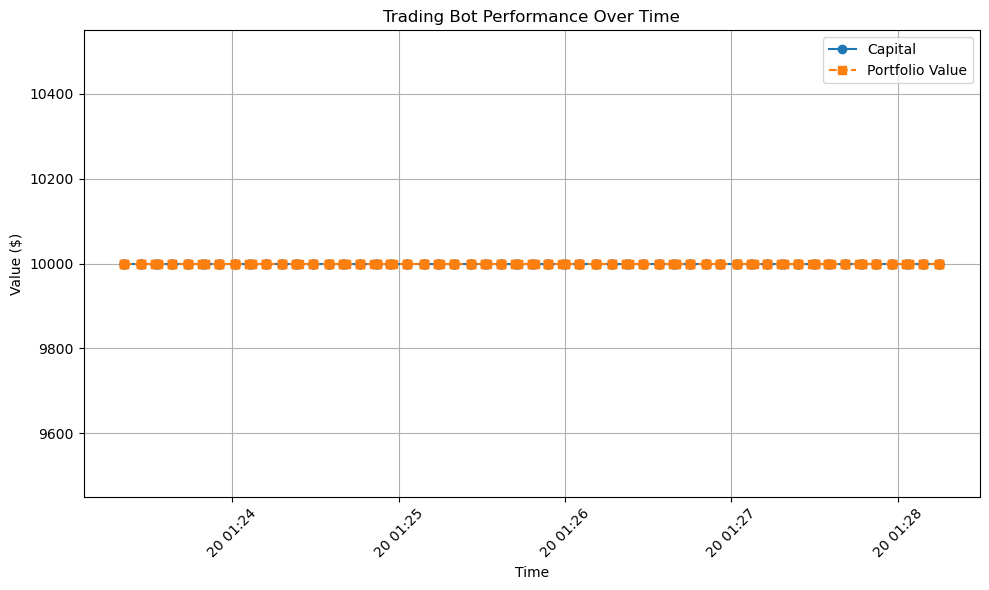

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the CSV file
csv_filename = "trading_data.csv"
df = pd.read_csv(csv_filename)

# Convert the 'Time' column to a datetime type for better plotting
df['Time'] = pd.to_datetime(df['Time'])

# Extract portfolio value from the "Portfolio" column
df['Portfolio Value'] = df['Capital'] + df['Portfolio'].apply(
    lambda portfolio: sum([float(stock.split(':')[1].strip()) for stock in str(portfolio)[1:-1].split(',') if ':' in stock]) if isinstance(portfolio, str) else 0
)

# Plot the capital and portfolio value over time
plt.figure(figsize=(10, 6))
plt.plot(df['Time'], df['Capital'], label="Capital", marker='o', linestyle='-')
plt.plot(df['Time'], df['Portfolio Value'], label="Portfolio Value", marker='s', linestyle='--')

# Set plot details
plt.title("Trading Bot Performance Over Time")
plt.xlabel("Time")
plt.ylabel("Value ($)")
plt.legend()
plt.grid()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the stock data from the CSV file
stock_csv_filename = "stock_data.csv"
stock_df = pd.read_csv(stock_csv_filename)

# Convert the 'Time' column to datetime for easier plotting
stock_df['Time'] = pd.to_datetime(stock_df['Time'])

# Plotting function
def plot_stock_data(stock_symbol):
    """
    Plot OHLC and Volume for the given stock symbol.
    """
    stock_data = stock_df[stock_df['Symbol'] == stock_symbol]
    
    if stock_data.empty:
        print(f"No data available for {stock_symbol}. Please check the symbol.")
        return

    # Create subplots for OHLC and Volume
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Plot OHLC (Open, High, Low, Close)
    ax1.plot(stock_data['Time'], stock_data['Open'], label='Open', color='blue', linestyle='-')
    ax1.plot(stock_data['Time'], stock_data['High'], label='High', color='green', linestyle='--')
    ax1.plot(stock_data['Time'], stock_data['Low'], label='Low', color='red', linestyle='--')
    ax1.plot(stock_data['Time'], stock_data['Close'], label='Close', color='black', linestyle='-')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Price ($)')
    ax1.legend(loc='upper left')
    ax1.grid()
    
    # Secondary axis for Volume
    ax2 = ax1.twinx()
    ax2.bar(stock_data['Time'], stock_data['Volume'], label='Volume', color='orange', alpha=0.3)
    ax2.set_ylabel('Volume')
    ax2.legend(loc='upper right')
    
    # Title and layout adjustments
    plt.title(f"Stock Data for {stock_symbol}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# List of unique stock symbols in the dataset
stock_symbols = stock_df['Symbol'].unique()
print("Available stocks in the dataset:", stock_symbols)

# Example: Visualize data for a specific stock symbol
# Replace 'AAPL' with the symbol you want to visualize
plot_stock_data('AAPL')

KeyError: 'Time'

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the stock data from the CSV file
stock_csv_filename = "stock_data.csv"
stock_df = pd.read_csv(stock_csv_filename)

# Convert 'datetime' column to datetime type for better plotting
stock_df['datetime'] = pd.to_datetime(stock_df['datetime'])

# Plotting function
def plot_stock_data(stock_symbol):
    """
    Plot OHLC and Volume for the given stock symbol.
    """
    # Filter data for the selected stock symbol
    stock_data = stock_df[stock_df['symbol'] == stock_symbol]
    
    if stock_data.empty:
        print(f"No data available for {stock_symbol}. Please check the symbol.")
        return

    # Create subplots for OHLC and Volume
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Plot OHLC (Open, High, Low, Close)
    ax1.plot(stock_data['datetime'], stock_data['open'], label='Open', color='blue', linestyle='-')
    ax1.plot(stock_data['datetime'], stock_data['high'], label='High', color='green', linestyle='--')
    ax1.plot(stock_data['datetime'], stock_data['low'], label='Low', color='red', linestyle='--')
    ax1.plot(stock_data['datetime'], stock_data['close'], label='Close', color='black', linestyle='-')
    ax1.set_xlabel('Datetime')
    ax1.set_ylabel('Price ($)')
    ax1.legend(loc='upper left')
    ax1.grid()
    
    # Secondary axis for Volume
    ax2 = ax1.twinx()
    ax2.bar(stock_data['datetime'], stock_data['volume'], label='Volume', color='orange', alpha=0.3)
    ax2.set_ylabel('Volume')
    ax2.legend(loc='upper right')
    
    # Title and layout adjustments
    plt.title(f"Stock Data for {stock_symbol}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# List of unique stock symbols in the dataset
stock_symbols = stock_df['symbol'].unique()
print("Available stocks in the dataset:", stock_symbols)

# Example: Visualize data for a specific stock symbol
# Replace 'AAPL' with the symbol you want to visualize
plot_stock_data('AAPL')


KeyError: 'datetime'

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the stock data from the CSV file
stock_csv_filename = "stock_data.csv"
stock_df = pd.read_csv(stock_csv_filename)

# Convert 'Datetime' column to datetime type for better plotting
stock_df['Datetime'] = pd.to_datetime(stock_df['Datetime'])

# Plotting function
def plot_stock_data(stock_symbol):
    """
    Plot OHLC and Volume for the given stock symbol.
    """
    # Filter data for the selected stock symbol
    stock_data = stock_df[stock_df['symbol'] == stock_symbol]
    
    if stock_data.empty:
        print(f"No data available for {stock_symbol}. Please check the symbol.")
        return

    # Create subplots for OHLC and Volume
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Plot OHLC (Open, High, Low, Close)
    ax1.plot(stock_data['Datetime'], stock_data['open'], label='Open', color='blue', linestyle='-')
    ax1.plot(stock_data['Datetime'], stock_data['high'], label='High', color='green', linestyle='--')
    ax1.plot(stock_data['Datetime'], stock_data['low'], label='Low', color='red', linestyle='--')
    ax1.plot(stock_data['Datetime'], stock_data['close'], label='Close', color='black', linestyle='-')
    ax1.set_xlabel('Datetime')
    ax1.set_ylabel('Price ($)')
    ax1.legend(loc='upper left')
    ax1.grid()
    
    # Secondary axis for Volume
    ax2 = ax1.twinx()
    ax2.bar(stock_data['Datetime'], stock_data['volume'], label='Volume', color='orange', alpha=0.3)
    ax2.set_ylabel('Volume')
    ax2.legend(loc='upper right')
    
    # Title and layout adjustments
    plt.title(f"Stock Data for {stock_symbol}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# List of unique stock symbols in the dataset
stock_symbols = stock_df['symbol'].unique()
print("Available stocks in the dataset:", stock_symbols)

# Example: Visualize data for a specific stock symbol
# Replace 'AAPL' with the symbol you want to visualize
plot_stock_data('AAPL')


KeyError: 'symbol'

Available stocks in the dataset: ['AAPL' 'GOOGL' 'MSFT' 'AMZN']


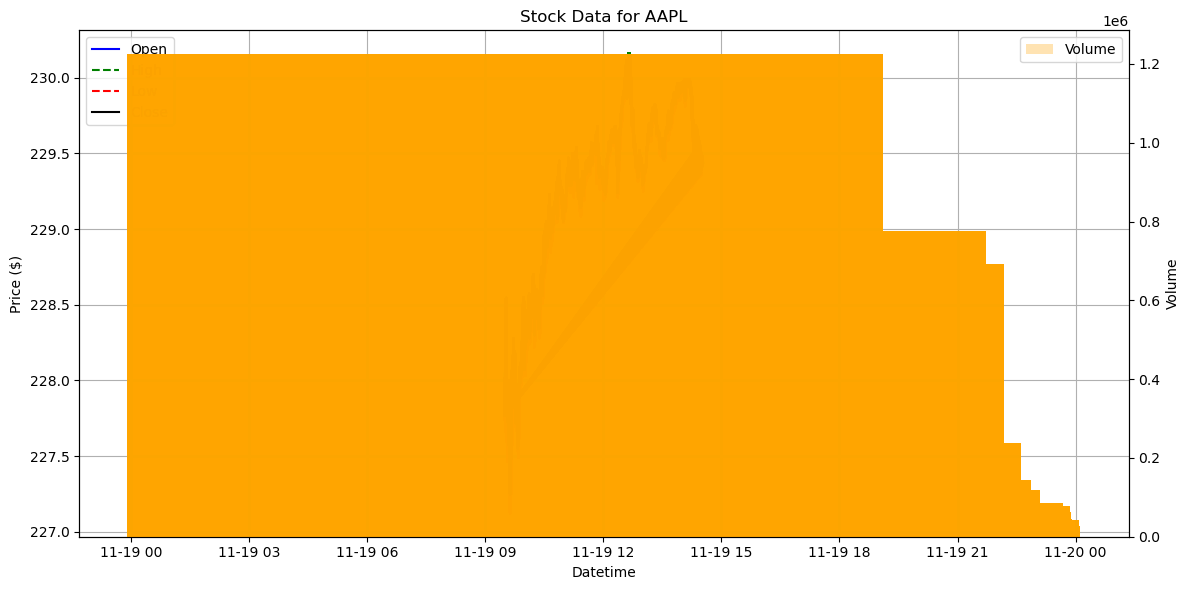

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the stock data from the CSV file
stock_csv_filename = "stock_data.csv"
stock_df = pd.read_csv(stock_csv_filename)

# Convert 'Datetime' column to datetime type for better plotting
stock_df['Datetime'] = pd.to_datetime(stock_df['Datetime'])

# Plotting function
def plot_stock_data(stock_symbol):
    """
    Plot OHLC and Volume for the given stock symbol.
    """
    # Filter data for the selected stock symbol
    stock_data = stock_df[stock_df['Symbol'] == stock_symbol]
    
    if stock_data.empty:
        print(f"No data available for {stock_symbol}. Please check the symbol.")
        return

    # Create subplots for OHLC and Volume
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Plot OHLC (Open, High, Low, Close)
    ax1.plot(stock_data['Datetime'], stock_data['Open'], label='Open', color='blue', linestyle='-')
    ax1.plot(stock_data['Datetime'], stock_data['High'], label='High', color='green', linestyle='--')
    ax1.plot(stock_data['Datetime'], stock_data['Low'], label='Low', color='red', linestyle='--')
    ax1.plot(stock_data['Datetime'], stock_data['Close'], label='Close', color='black', linestyle='-')
    ax1.set_xlabel('Datetime')
    ax1.set_ylabel('Price ($)')
    ax1.legend(loc='upper left')
    ax1.grid()
    
    # Secondary axis for Volume
    ax2 = ax1.twinx()
    ax2.bar(stock_data['Datetime'], stock_data['Volume'], label='Volume', color='orange', alpha=0.3)
    ax2.set_ylabel('Volume')
    ax2.legend(loc='upper right')
    
    # Title and layout adjustments
    plt.title(f"Stock Data for {stock_symbol}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# List of unique stock symbols in the dataset
stock_symbols = stock_df['Symbol'].unique()
print("Available stocks in the dataset:", stock_symbols)

# Example: Visualize data for a specific stock symbol
# Replace 'AAPL' with the symbol you want to visualize
plot_stock_data('AAPL')

plt.show()


In [11]:
!pip install seaborn

Available stocks in the dataset: ['AAPL' 'GOOGL' 'MSFT' 'AMZN']


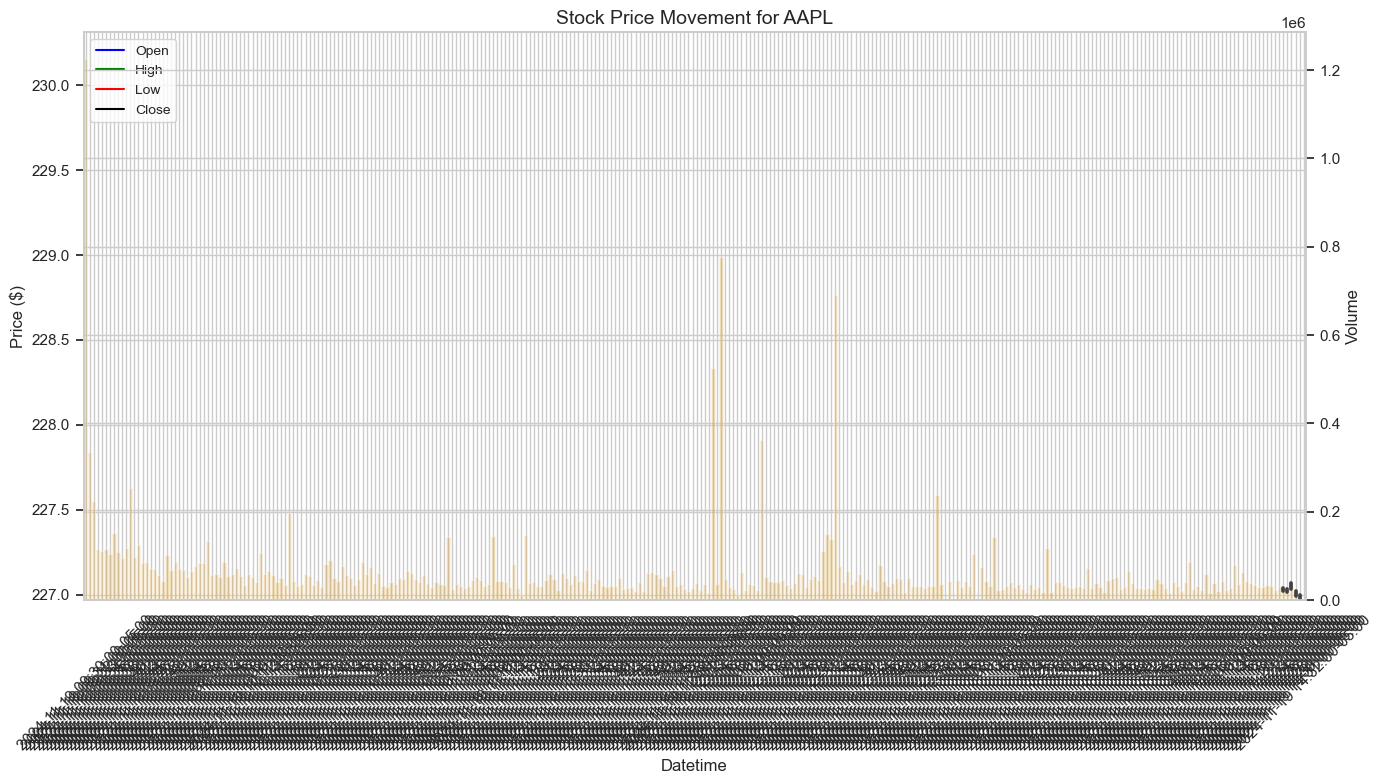

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the stock data from the CSV file
stock_csv_filename = "stock_data.csv"
stock_df = pd.read_csv(stock_csv_filename)

# Convert 'Datetime' column to datetime type for better plotting
stock_df['Datetime'] = pd.to_datetime(stock_df['Datetime'])

# Plotting function
def visualize_stock_data(stock_symbol):
    """
    Visualize stock data using Seaborn and Matplotlib for a specific stock symbol.
    """
    # Filter data for the selected stock symbol
    stock_data = stock_df[stock_df['Symbol'] == stock_symbol]
    
    if stock_data.empty:
        print(f"No data available for {stock_symbol}. Please check the symbol.")
        return

    # Set Seaborn style
    sns.set_theme(style="whitegrid")

    # Create a figure with two subplots: one for OHLC and one for Volume
    fig, ax1 = plt.subplots(figsize=(14, 8))
    
    # Plot Open, High, Low, Close using Seaborn lineplot
    sns.lineplot(x='Datetime', y='Open', data=stock_data, label='Open', ax=ax1, color='blue')
    sns.lineplot(x='Datetime', y='High', data=stock_data, label='High', ax=ax1, color='green')
    sns.lineplot(x='Datetime', y='Low', data=stock_data, label='Low', ax=ax1, color='red')
    sns.lineplot(x='Datetime', y='Close', data=stock_data, label='Close', ax=ax1, color='black')
    
    ax1.set_xlabel('Datetime', fontsize=12)
    ax1.set_ylabel('Price ($)', fontsize=12)
    ax1.legend(loc='upper left', fontsize=10)
    ax1.set_title(f"Stock Price Movement for {stock_symbol}", fontsize=14)
    
    # Rotate x-axis labels for better visibility
    plt.xticks(rotation=45)

    # Add a secondary axis for Volume
    ax2 = ax1.twinx()
    sns.barplot(x='Datetime', y='Volume', data=stock_data, ax=ax2, color='orange', alpha=0.3)
    ax2.set_ylabel('Volume', fontsize=12)
    
    plt.tight_layout()
    plt.show()

# List of unique stock symbols in the dataset
stock_symbols = stock_df['Symbol'].unique()
print("Available stocks in the dataset:", stock_symbols)

# Example: Visualize data for a specific stock symbol
# Replace 'AAPL' with the symbol you want to visualize
visualize_stock_data('AAPL')


Available stocks in the dataset: ['AAPL' 'GOOGL' 'MSFT' 'AMZN']


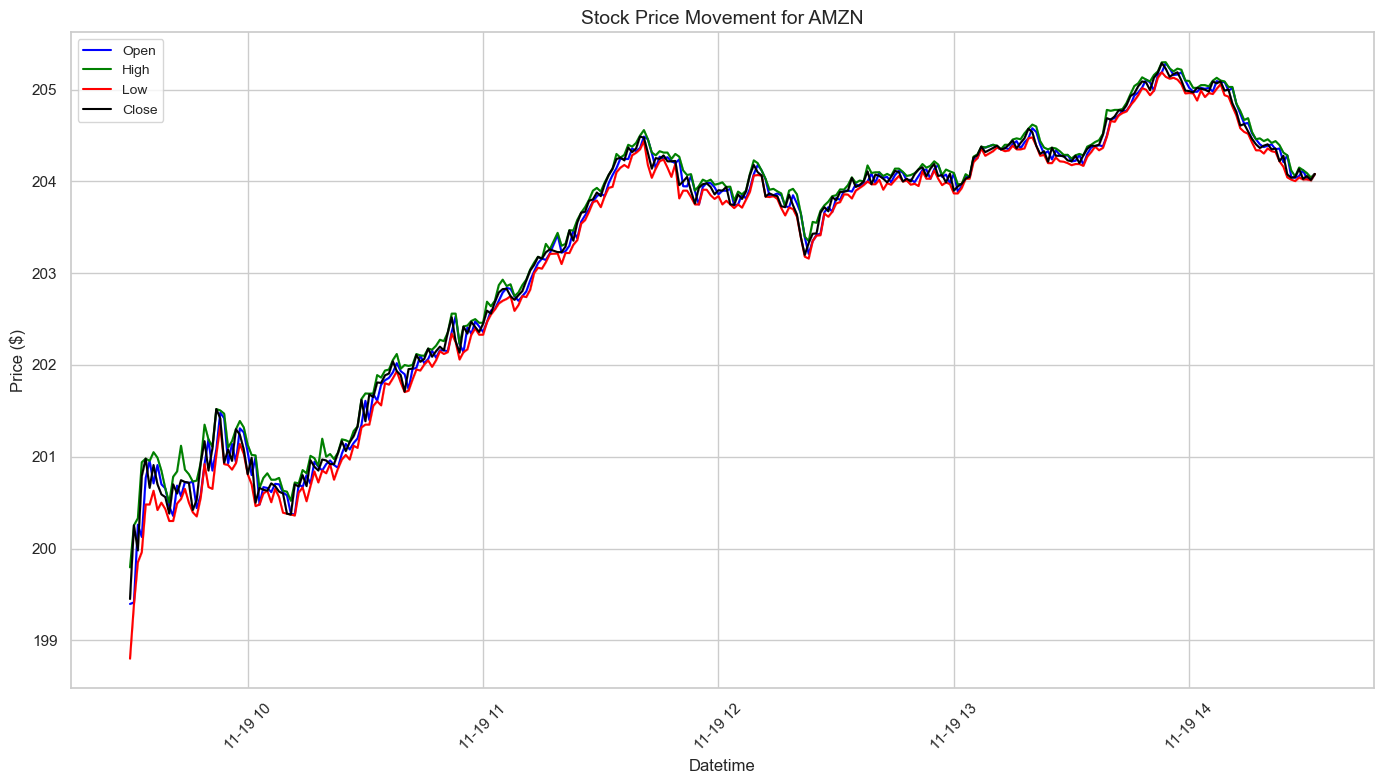

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the stock data from the CSV file
stock_csv_filename = "stock_data.csv"
stock_df = pd.read_csv(stock_csv_filename)

# Convert 'Datetime' column to datetime type for better plotting
stock_df['Datetime'] = pd.to_datetime(stock_df['Datetime'])

# Plotting function for a line graph
def plot_line_graph(stock_symbol):
    """
    Plot line graph for Open, High, Low, Close prices for a given stock symbol.
    """
    # Filter data for the selected stock symbol
    stock_data = stock_df[stock_df['Symbol'] == stock_symbol]
    
    if stock_data.empty:
        print(f"No data available for {stock_symbol}. Please check the symbol.")
        return

    # Set Seaborn style
    sns.set_theme(style="whitegrid")

    # Create a figure for the line plot
    plt.figure(figsize=(14, 8))

    # Plot Open, High, Low, Close prices
    sns.lineplot(x='Datetime', y='Open', data=stock_data, label='Open', color='blue')
    sns.lineplot(x='Datetime', y='High', data=stock_data, label='High', color='green')
    sns.lineplot(x='Datetime', y='Low', data=stock_data, label='Low', color='red')
    sns.lineplot(x='Datetime', y='Close', data=stock_data, label='Close', color='black')
    
    # Set labels and title
    plt.xlabel('Datetime', fontsize=12)
    plt.ylabel('Price ($)', fontsize=12)
    plt.title(f"Stock Price Movement for {stock_symbol}", fontsize=14)
    
    # Rotate x-axis labels for better visibility
    plt.xticks(rotation=45)

    # Show the legend
    plt.legend(loc='upper left', fontsize=10)

    # Display the plot
    plt.tight_layout()
    plt.show()

# List of unique stock symbols in the dataset
stock_symbols = stock_df['Symbol'].unique()
print("Available stocks in the dataset:", stock_symbols)

# Example: Visualize data for a specific stock symbol
# Replace 'AAPL' with the symbol you want to visualize
plot_line_graph('AMZN')
